# Generalized Cross-Validation for Non-Ensemble Models

In [1]:
import sys
sys.path.append('..')

import os
n_cores = int(8)
os.environ["OMP_NUM_THREADS"] = f"{n_cores}"
os.environ["OPENBLAS_NUM_THREADS"] = f"{n_cores}"
os.environ["MKL_NUM_THREADS"] = f"{n_cores}"
os.environ["VECLIB_MAXIMUM_THREADS"] = f"{n_cores}"
os.environ["NUMEXPR_NUM_THREADS"] = f"{n_cores}"
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'

import numpy as np
from sklearn_ensemble_cv import reset_random_seeds
import matplotlib.pyplot as plt

reset_random_seeds(0)

## GCV for risk estimation

In [2]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn_ensemble_cv import generate_data, Ensemble

reset_random_seeds(0)
n_samples, n_features = 1000, 800
Sigma, beta0, X_train, y_train, X_test, y_test, _, _ = generate_data(
    n_samples, n_features, coef='random', func='quad', sigma_quad=.1,
    rho_ar1=0., sigma=.5, df=np.inf, n_test=1000, 
)

kwargs_regr = {'alpha': 0.01*X_train.shape[0], 'fit_intercept':False}
kwargs_ensemble = {'max_samples': 0.5, 'bootstrap':False}
regr = Ensemble(estimator=Ridge(**kwargs_regr), n_estimators=1, **kwargs_ensemble)
regr = regr.fit(X_train, y_train)

In [3]:
df_gcv = regr.compute_gcv_estimate(X_train, y_train, M0=1, type='union', return_df=True)
df_gcv

,M,estimate,err_train,deno
0,1,0.986995,0.000927,0.00094


In [4]:
df_risk = regr.compute_risk(X_test, y_test, return_df=True)
df_risk

,M,risk
0,1,1.015682


## GCV for tuning regularization parameters


In [5]:
from sklearn_ensemble_cv import GCV

grid_regr = {'alpha': np.logspace(-3, 0, 10)*X_train.shape[0]}
grid_ensemble = {'max_samples': 1., 'bootstrap':False}

res_gcv, info_gcv = GCV(
        X_train, y_train, Ridge, grid_regr, grid_ensemble,
        M=1, M0=1, corrected=True, type='full', return_df=True, X_test=X_test, Y_test=y_test,
        )

In [6]:
res_gcv

,alpha,risk_val-1,risk_val-inf,risk_test-1
0,1.000000,1.281178,NaN,1.228796
1,2.154435,1.231096,NaN,1.167976
2,4.641589,1.144019,NaN,1.066096
3,10.000000,1.015488,NaN,0.923820
4,21.544347,0.863445,NaN,0.767550
5,46.415888,0.723675,NaN,0.639160
6,100.000000,0.627298,NaN,0.568579
7,215.443469,0.592169,NaN,0.563968
8,464.158883,0.625508,NaN,0.623591
9,1000.000000,0.721912,NaN,0.740226


In [7]:
info_gcv

{'best_params_regr': {'alpha': np.float64(215.44346900318823)},
 'best_params_ensemble': {'random_state': 0,
  'max_samples': 1.0,
  'bootstrap': False,
  'n_estimators': 1},
 'best_n_estimators': np.int64(1),
 'best_params_index': np.int64(7),
 'best_score': np.float64(0.5921689022419518)}

In [8]:
res_gcv.iloc[info_gcv['best_params_index']]['risk_test-{}'.format(info_gcv['best_n_estimators'])]

np.float64(0.5639675571939373)

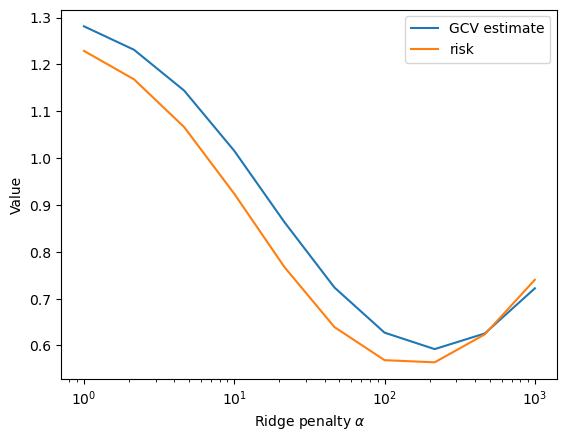

In [9]:
plt.plot(res_gcv['alpha'], res_gcv['risk_val-1'], label='GCV estimate')
plt.plot(res_gcv['alpha'], res_gcv['risk_test-1'], label='risk')
plt.xscale('log')
plt.xlabel(r'Ridge penalty $\alpha$')
plt.ylabel('Value')
plt.legend()
plt.show()